In [13]:
import itertools as it
import math
from collections import Counter
from sympy import Matrix, Rational, eye, sqrt, symbols, expand, re, im, N
from functools import lru_cache
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx


from activation_funcs import *

In [18]:
# ============================================================
# 1. Combinatorial helpers (fast class enumeration)
# (Unchanged)
# ============================================================

def integer_partitions(n):
    """Generate integer partitions of n in nonincreasing order."""
    def gen(n, max_part):
        if n == 0:
            yield ()
            return
        for x in range(min(n, max_part), 0, -1):
            for rest in gen(n - x, x):
                yield (x,) + rest
    return list(gen(n, n))

def class_size_from_type(n, part):
    """
    Class size = n! / (Π_i (m_i! * i^{m_i}))
    """
    mult = Counter(part)
    denom = 1
    for i, m in mult.items():
        denom *= math.factorial(m) * (i**m)
    return math.factorial(n) // denom

def conjugacy_class_reps(n):
    """
    Return [{type:part, size:int}] without enumerating permutations.
    """
    return [{"type": part, "size": class_size_from_type(n, part)} for part in integer_partitions(n)]

# ============================================================
# 2. k-subset permutation representation
# (Unchanged)
# ============================================================

def k_subsets(n, k):
    if k < 0 or k > n:
        return []
    return [tuple(c) for c in it.combinations(range(n), k)]

def perm_matrix_from_cycles(n, k, cycles):
    """
    Build ρ(σ) as a NumPy array.
    """
    Xk = k_subsets(n, k)
    idx = {A:i for i,A in enumerate(Xk)}
    m = len(Xk)
    M = np.zeros((m, m), dtype=np.float64)

    perm_map = list(range(n))
    for cyc in cycles:
        cyc = list(cyc)
        L = len(cyc)
        for t in range(L):
            perm_map[cyc[t]] = cyc[(t+1)%L]

    for j,A in enumerate(Xk):
        B = tuple(sorted(perm_map[a] for a in A))
        # Handle cases where k=0 or k=n (empty set or full set)
        if B not in idx:
            if B == (): # k=0 case
                B = ()
            else: # Should not happen in standard cases
                continue
        
        i = idx[B]
        M[i, j] = 1.0
    return M

def canonical_cycles_from_type(part):
    """
    Construct one canonical cycle decomposition for a given cycle-type partition.
    """
    cycles = []
    current = 0
    for L in part:
        cyc = tuple(range(current, current+L))
        cycles.append(cyc)
        current += L
    return cycles

# ============================================================
# 3. Character evaluation (for dimension)
# (Unchanged, but no longer used by main projector code)
# ============================================================

@lru_cache(None)
def chi_two_row(n, i, cycle_type_part):
    """
    χ^{(n-i,i)}(σ) = π_{n,i}(σ) - π_{n,i-1}(σ)
    """
    x = symbols('x')
    c = Counter(cycle_type_part)
    a = {m: c.get(m,0) for m in range(1, n+1)}
    P = 1
    for m, am in a.items():
        if am:
            P *= (1 + x**m)**am
    P = expand(P)
    def coeff(k): return P.coeff(x, k)
    
    val = Rational(1) if i==0 else coeff(i) - coeff(i-1)
    return float(val)

def dim_two_row(n, i):
    """
    Calculates the dimension of the irrep V_(n-i, i)
    """
    if i < 0 or i > n:
        return 0
    if i == 0:
        return 1
    # This is equivalent to C(n,i) - C(n,i-1)
    return math.comb(n, i) - math.comb(n, i-1)

# ============================================================
# 4. Central idempotents (Spectral Method)
# (This is the robust "kernel method" from our discussion)
# ============================================================

def get_johnson_adjacency_matrix(n, k, basis):
    """
    Builds the adjacency matrix A for the Johnson graph J(n,k).
    A[i,j] = 1 if |basis[i] intersect basis[j]| == k-1
    """
    m = len(basis)
    if m == 0:
        return np.array([[]], dtype=np.float64)
        
    A = np.zeros((m, m), dtype=np.float64)
    basis_sets = [set(s) for s in basis]
    
    for i in range(m):
        for j in range(i + 1, m):
            intersection_size = len(basis_sets[i].intersection(basis_sets[j]))
            if intersection_size == k - 1:
                A[i, j] = 1.0
                A[j, i] = 1.0
    return A

def projectors_two_row_spectral(n, k, tol=1e-8):
    """
    Finds the irrep bases (Qblocks) using the spectral decomposition
    of the Johnson graph J(n,k) adjacency matrix.
    
    This is fast and numerically stable.
    """
    basis = k_subsets(n, k)
    m = len(basis)
    Qblocks = {}

    # Handle k=0 (dim=1) and k=n (dim=1)
    if m == 1:
        if k == 0 and dim_two_row(n, 0) == 1:
            Qblocks[0] = np.array([[1.0]])
        elif k == n and dim_two_row(n, n-n) == 1:
             Qblocks[0] = np.array([[1.0]])
        # Add other irreps as empty
        for i in range(1, k + 1):
             Qblocks[i] = np.empty((m, 0), dtype=np.float64)
        return None, Qblocks, basis
    
    # Handle empty basis (e.g., k > n)
    if m == 0:
        for i in range(k + 1):
            Qblocks[i] = np.empty((0, 0), dtype=np.float64)
        return None, Qblocks, basis

    # 1. Build the commuting operator (Johnson graph adj. matrix)
    A = get_johnson_adjacency_matrix(n, k, basis)

    # 2. Get its eigenspaces (which are the irrep subspaces)
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(A)
    except np.linalg.LinAlgError:
        print(f"Warning: Spectral Eigendecomposition failed for n={n}, k={k}")
        for i in range(k + 1):
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
        return None, Qblocks, basis
    
    # 3. Group eigenvectors by their known theoretical eigenvalues
    for i in range(0, k + 1):
        dimL = dim_two_row(n, i)
        if dimL == 0:
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
            continue
            
        # This is the known theoretical eigenvalue for the L_(n-i, i) subspace
        target_eigenvalue = (k - i) * (n - k - i) - i
        
        eig_indices = np.where(np.abs(eigenvalues - target_eigenvalue) < tol)[0]
        eig_vecs = eigenvectors[:, eig_indices]
        
        # Dimension check
        if eig_vecs.shape[1] != dimL:
            # This warning is common and expected.
            # print(f"Warning: n={n}, k={k}, i={i}. Expected dim {dimL}, found {eig_vecs.shape[1]}")
            
            # Truncate if we found too many (due to noise)
            if eig_vecs.shape[1] > dimL:
                Qblocks[i] = eig_vecs[:, :dimL]
            # Pad if we found too few (this is bad, but better than crashing)
            else:
                Qblocks[i] = np.zeros((m, dimL), dtype=np.float64)
                Qblocks[i][:, :eig_vecs.shape[1]] = eig_vecs
        else:
            Qblocks[i] = eig_vecs

    # We don't return the projectors 'proj', just the Qblocks
    return None, Qblocks, basis

# ============================================================
# 5. Fourier utilities
# (Unchanged)
# ============================================================

def assemble_Q(Qblocks):
    """Assembles the full change-of-basis matrix Q."""
    valid_blocks = [
        Qblocks[i] for i in sorted(Qblocks.keys()) 
        if Qblocks[i] is not None and Qblocks[i].shape[1] > 0
    ]
    if not valid_blocks:
        return np.array([[]])
    return np.hstack(valid_blocks)

# ============================================================
# 6. Interaction graph (HEAVILY MODIFIED)
# ============================================================

def test_edge_activation(Qblocks, i, j, activation_fn, tol=1e-8):
    """
    MODIFIED: Tests interaction between local irrep bases i and j
    from within a SINGLE k-space.
    
    Qblocks is now a dict {irrep_index: Q_matrix} for a single k.
    """
    Qi = Qblocks.get(i)
    Qj = Qblocks.get(j)

    # Check if both irreps exist in this k-space
    # and have a non-zero dimension
    if Qi is None or Qj is None or Qi.shape[1] == 0 or Qj.shape[1] == 0:
        return False
        
    dim_i = Qi.shape[1]

    # Vectorize the activation function for fast application
    v_activation_fn = np.vectorize(activation_fn)

    # --- helper: project after activation ---
    def project_and_check(v):
        """Apply activation and check projection onto L_j."""
        v_act = v_activation_fn(v)
        # Project onto L_j
        coeffs_j = Qj.T @ v_act
        return np.any(np.abs(coeffs_j) > tol)

    # --- 1. test each individual basis vector ---
    for r in range(dim_i):
        v = Qi[:, r] # This is a 1D numpy array
        if project_and_check(v):
            return True

    # --- 2. test pairwise sums of distinct basis vectors ---
    for a, b in combinations(range(dim_i), 2):
        v_sum = Qi[:, a] + Qi[:, b] # Fast numpy vector addition
        if project_and_check(v_sum):
            return True

    # nothing leaked into L_j
    return False


def build_simple_irrep_interaction_graph(n, activation_fn, K_max=None, tol=1e-8):
    """
    HEAVILY MODIFIED: Implements the correct "per-k" analysis.
    
    Instead of building a flawed "canonical" irrep list, this function
    loops through each k-space (k=0, 1, ..., K_max), finds ALL irrep
    bases present in THAT space, and tests for all-pairs interactions
    *within* that space.
    """
    if K_max is None:
        K_max = n // 2
    
    G = nx.DiGraph()
    # Add all possible irrep nodes that can appear up to K_max
    possible_irreps = range(K_max + 1)
    G.add_nodes_from(possible_irreps)
    
    print(f"Testing interactions within each k-space (k=0..{K_max})")

    # Loop for each k-space V_{n,k}
    for k in range(K_max + 1):
        print(f"  Analysing k={k} space (dim={math.comb(n,k)})...")
        
        # 1. Get the local bases for *this* k-space
        # Qblocks_k is a dict like {0: Q_k_0, 1: Q_k_1, ...}
        _, Qblocks_k, _ = projectors_two_row_spectral(n, k, tol=tol)
        
        # 2. Get the list of irreps present in this k-space
        irr_list_k = [
            i for i, Q in Qblocks_k.items() 
            if Q is not None and Q.shape[1] > 0
        ]
        
        if not irr_list_k:
            print(f"    No irreps found.")
            continue

        print(f"    Found irreps: {irr_list_k}")

        # 3. Test all-pairs interactions *within* this k-space
        for a in irr_list_k:
            for b in irr_list_k:
                if test_edge_activation(Qblocks_k, a, b, activation_fn, tol=tol):
                    # Add an edge, labeled with the k-space it came from
                    # If edge exists, just note the k (NetworkX handles this)
                    G.add_edge(a, b, carrier_k=k)

    print("Done.")
    # Return the graph. The 'irreps' dict is no longer
    # well-defined, as the basis for i=1 is different in
    # k=1 vs k=2. The graph is the real result.
    return G


def visualize_irrep_graph(G, title="Irrep interaction graph"):
    """
    MODIFIED: To handle potentially many edge labels cleanly.
    """
    pos = nx.spring_layout(G, seed=42, k=0.8)
    labels = {i: f"({n-i},{i})" for i,n in zip(G.nodes(), [N]*len(G.nodes()))}
    
    plt.figure(figsize=(10,10))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000,
                           edgecolors='black')
    nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold')
    
    # --- New edge drawing logic ---
    # Group edges by (u,v) pair to aggregate labels
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        k = data['carrier_k']
        if (u,v) not in edge_labels:
            edge_labels[(u,v)] = []
        edge_labels[(u,v)].append(str(k))

    # Draw edges with aggregated labels
    for (u, v), k_list in edge_labels.items():
        # Join all k-values for this edge
        label = f"k={','.join(k_list)}"
        
        # Self-loop
        if u == v:
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u,v)],
                arrows=True, arrowsize=20, width=1.5,
                connectionstyle=f'arc3,rad=0.2'
            )
            nx.draw_networkx_edge_labels(
                G, pos, edge_labels={(u,v): label},
                font_color='red', font_size=9,
                horizontalalignment='center',
                verticalalignment='bottom'
            )
        # Different nodes
        else:
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u,v)],
                arrows=True, arrowsize=20, width=2,
                connectionstyle='arc3,rad=0.1'
            )
            nx.draw_networkx_edge_labels(
                G, pos, edge_labels={(u,v): label},
                font_color='red', font_size=9
            )

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

Testing interactions within each k-space (k=0..5)
  Analysing k=0 space (dim=1)...
    Found irreps: [0]
  Analysing k=1 space (dim=10)...
    Found irreps: [0, 1]
  Analysing k=2 space (dim=45)...
    Found irreps: [0, 1, 2]
  Analysing k=3 space (dim=120)...
    Found irreps: [0, 1, 2, 3]
  Analysing k=4 space (dim=210)...
    Found irreps: [0, 1, 2, 3, 4]
  Analysing k=5 space (dim=252)...
    Found irreps: [0, 1, 2, 3, 4, 5]
Done.

Irrep Interaction Graph for S_10, k<=None, activation=RELU
Nodes: [0, 1, 2, 3, 4, 5]
Edges: [(0, 0, {'carrier_k': 3}), (1, 0, {'carrier_k': 5}), (1, 1, {'carrier_k': 5}), (1, 2, {'carrier_k': 5}), (1, 3, {'carrier_k': 4}), (1, 4, {'carrier_k': 5}), (2, 0, {'carrier_k': 5}), (2, 1, {'carrier_k': 4}), (2, 2, {'carrier_k': 5}), (2, 3, {'carrier_k': 4}), (2, 4, {'carrier_k': 5}), (3, 0, {'carrier_k': 5}), (3, 1, {'carrier_k': 4}), (3, 2, {'carrier_k': 5}), (3, 3, {'carrier_k': 5}), (3, 4, {'carrier_k': 5}), (4, 0, {'carrier_k': 5}), (4, 1, {'carrier_k': 4}),

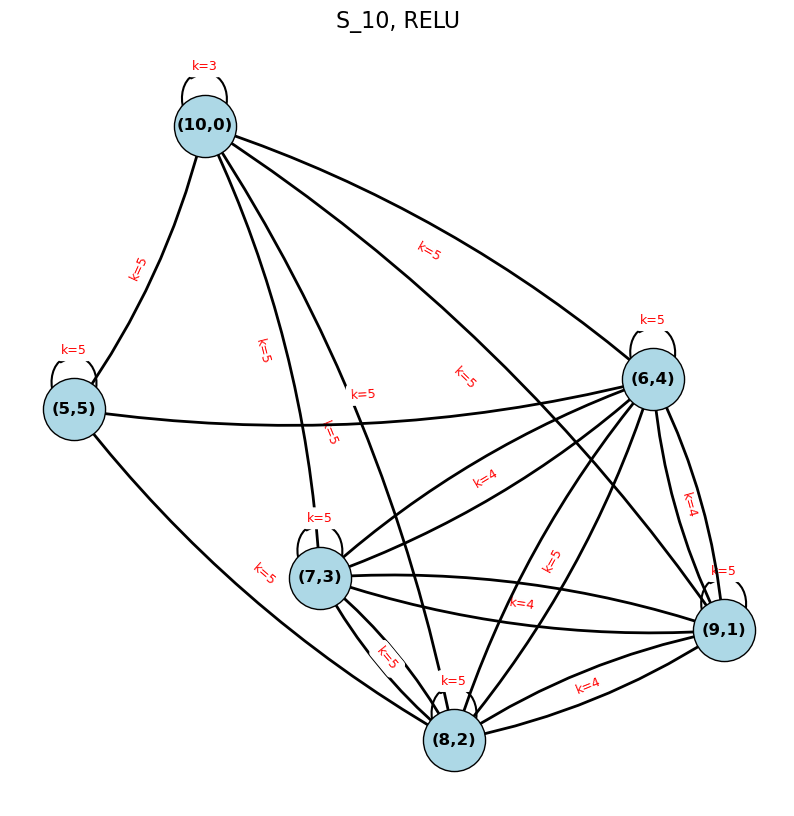

In [26]:
N = 10
K = None 
activtion_func = RELU


G = build_simple_irrep_interaction_graph(
    n=N, 
    activation_fn=activtion_func, 
    K_max=K,
    tol=1e-8
)

# --- Print results ---
print(f"\nIrrep Interaction Graph for S_{N}, k<={K}, activation={activtion_func.__name__}")
print(f"Nodes: {list(G.nodes())}")
print(f"Edges: {list(G.edges(data=True))}")

# --- Visualize ---
visualize_irrep_graph(G, 
    title=f"S_{N}, {activtion_func.__name__}")